# False Positive Classifier - Model Evaluation & Deployment

## Project Context

This notebook is part of an **ESG News Monitoring System** that tracks sustainability trends for 50 sportswear and outdoor apparel brands. The False Positive (FP) classifier is the **first filter in the pipeline**, distinguishing articles that are actually about sportswear brands from false positives where brand names match unrelated entities.

**Pipeline Position:** Data Collection → **FP Filter (this classifier)** → EP Filter → LLM Labeling

---

## Notebook Objective

This is the **final evaluation notebook** for the FP classifier. It performs:

1. **Test set evaluation** - Unbiased performance assessment on held-out data
2. **Threshold optimization** - Find optimal decision boundary for target recall
3. **Deployment export** - Package model artifacts for production API
4. **Model explainability** - LIME, SHAP feature groups, and prototype explanations

**Important:** This is the ONLY notebook that uses the test set. All model selection and tuning was performed in fp2 using cross-validation.

---

## Technical Approach

### Evaluation Methodology
- **Generalization Check:** Compare CV metrics from fp2 against test set performance
- **Metrics:** F2 score (primary), recall, precision, accuracy, PR-AUC, confusion matrix
- **Gap Analysis:** Flag significant degradation (>5%) between CV and test performance

### Threshold Optimization
- **Target Recall:** 99% (prioritize catching all sportswear articles)
- **Trade-off Analysis:** Precision-recall curves at multiple target recall levels
- **Business Logic:** Lower threshold = higher recall, more FPs pass to downstream LLM

### Deployment Artifacts
| Artifact | Description |
|----------|-------------|
| `fp_classifier_pipeline.joblib` | Complete sklearn Pipeline (transformer + classifier) |
| `fp_classifier_config.json` | Threshold, metrics, hyperparameters for API configuration |

### Pipeline Validation
- Test on realistic articles with known labels
- Verify edge cases: brand name ambiguity (Puma animal, Patagonia region, etc.)
- Confirm probability calibration for threshold-based decisions

### Model Explainability

Three complementary approaches to interpret predictions from text classifiers with abstract features (TF-IDF/LSA, embeddings, NER-derived features):

| Method | What It Shows | Use Case |
|--------|---------------|----------|
| **SHAP Feature Groups** | Which feature types matter most (LSA, NER, proximity, brand indicators) | Understanding model behavior at a high level |
| **LIME Word-Level** | Specific words that influenced individual predictions | Debugging specific predictions, stakeholder explanations |
| **Prototype Explanations** | Similar training examples ("this article is like these known examples") | Building intuition, catching label errors |

**Production Integration Options:**
- `/predict?explain=lime` - Word-level explanations
- `/predict?explain=prototype` - Similar example lookup
- `/model/explain` - Feature group importance summary

---

## Contents

1. [Setup](#setup)
2. [Data Loading & Split](#1-data-loading--split)
3. [Load Artifacts from fp1/fp2](#2-load-artifacts-from-fp1fp2)
4. [Test Set Evaluation](#3-test-set-evaluation)
5. [Threshold Optimization](#4-threshold-optimization)
6. [Model Explainability](#5-model-explainability)
7. [Export for Deployment](#6-export-for-deployment)
8. [Pipeline Validation](#7-pipeline-validation)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sklearn imports
from sklearn.metrics import fbeta_score

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import load_jsonl_data, split_train_val_test
from src.fp1_nb.preprocessing import clean_text, create_text_features
from src.fp1_nb.modeling import evaluate_model
from src.fp3_nb.threshold_optimization import (
    find_optimal_threshold,
    analyze_threshold_tradeoffs,
    plot_threshold_analysis,
)
from src.fp3_nb.deployment import (
    create_deployment_pipeline,
    save_deployment_artifacts,
    validate_pipeline_with_articles,
)

# Explainability imports
from src.fp3_nb.explainability import (
    TextExplainer,
    get_fp_feature_groups,
    explain_prediction,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TARGET_COL = 'is_sportswear'
TARGET_RECALL = 0.99  # Target recall for threshold optimization

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

print("Setup complete!")

Setup complete!


## 1. Data Loading & Split

Load data and apply identical preprocessing and split as fp1/fp2 to ensure consistency.

In [2]:
# Load the FP training data (same as fp1/fp2)
df = load_jsonl_data(DATA_PATH)

# Create combined text features (identical to fp1/fp2)
# Includes metadata (source_name, category) for consistency
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print(f"\nText features created!")

Loaded 1,356 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 9.77 MB

Text features created!


In [3]:
# Split with stratification (identical to fp1/fp2 - same random_state ensures identical splits)
train_df, val_df, test_df = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=RANDOM_STATE
)

# Extract metadata for discrete metadata features (same as fp1/fp2)
test_source_names = test_df['source_name'].tolist()
test_categories = test_df['category'].tolist()

TRAIN/VALIDATION/TEST SPLIT

Total samples: 1,356

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      813 (60.0%)
  Validation: 271 (20.0%)
  Test:       272 (20.1%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 81.2%, 0: 18.8%
  Val: 1: 81.2%, 0: 18.8%
  Test: 1: 81.2%, 0: 18.8%


## 2. Load Artifacts from fp1/fp2

Load the feature transformer from fp1 and the best classifier from fp2.

In [4]:
# Load feature transformer from fp1
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
transformer = joblib.load(transformer_path)
print(f"Loaded transformer: {transformer}")

# Load best classifier from fp2
classifier_path = MODELS_DIR / 'fp_best_classifier.joblib'
best_model = joblib.load(classifier_path)
print(f"Loaded classifier: {type(best_model).__name__}")

# Load CV metrics from fp2
cv_metrics_path = MODELS_DIR / 'fp_cv_metrics.json'
with open(cv_metrics_path) as f:
    cv_metrics = json.load(f)

print(f"\nCV Metrics (from fp2):")
print(f"  Model: {cv_metrics['model_name']}")
print(f"  CV F2: {cv_metrics['cv_f2']:.4f}")
print(f"  CV Recall: {cv_metrics['cv_recall']:.4f}")
print(f"  CV Precision: {cv_metrics['cv_precision']:.4f}")

Loaded transformer: FPFeatureTransformer(method='tfidf_lsa_ner_proximity_brands', max_features=10000, fitted=True)
Loaded classifier: RandomForestClassifier

CV Metrics (from fp2):
  Model: RF_tuned
  CV F2: 0.9825
  CV Recall: 0.9932
  CV Precision: 0.9418


In [5]:
# Transform test set using the fitted transformer
# Pass metadata for discrete metadata features (consistent with fp1/fp2)
X_test = transformer.transform(
    test_df['text_features'],
    source_names=test_source_names,
    categories=test_categories
)
y_test = test_df[TARGET_COL].values

print(f"X_test shape: {X_test.shape}")
print(f"y_test distribution: {pd.Series(y_test).value_counts().to_dict()}")

X_test shape: (272, 393)
y_test distribution: {1: 221, 0: 51}


## 3. Test Set Evaluation

Evaluate the best model on the held-out test set (used only once, here).


MODEL EVALUATION: RF_tuned on Test

Classification Metrics:
  Accuracy:  0.9559
  Precision: 0.9686
  Recall:    0.9774
  F1 Score:  0.9730
  ROC-AUC:   0.9879
  PR-AUC:    0.9972

Confusion Matrix:
  TN: 44  FP: 7
  FN: 5  TP: 216

                precision    recall  f1-score   support

Not Sportswear       0.90      0.86      0.88        51
    Sportswear       0.97      0.98      0.97       221

      accuracy                           0.96       272
     macro avg       0.93      0.92      0.93       272
  weighted avg       0.96      0.96      0.96       272

Figure saved to images/fp_test_evaluation.png


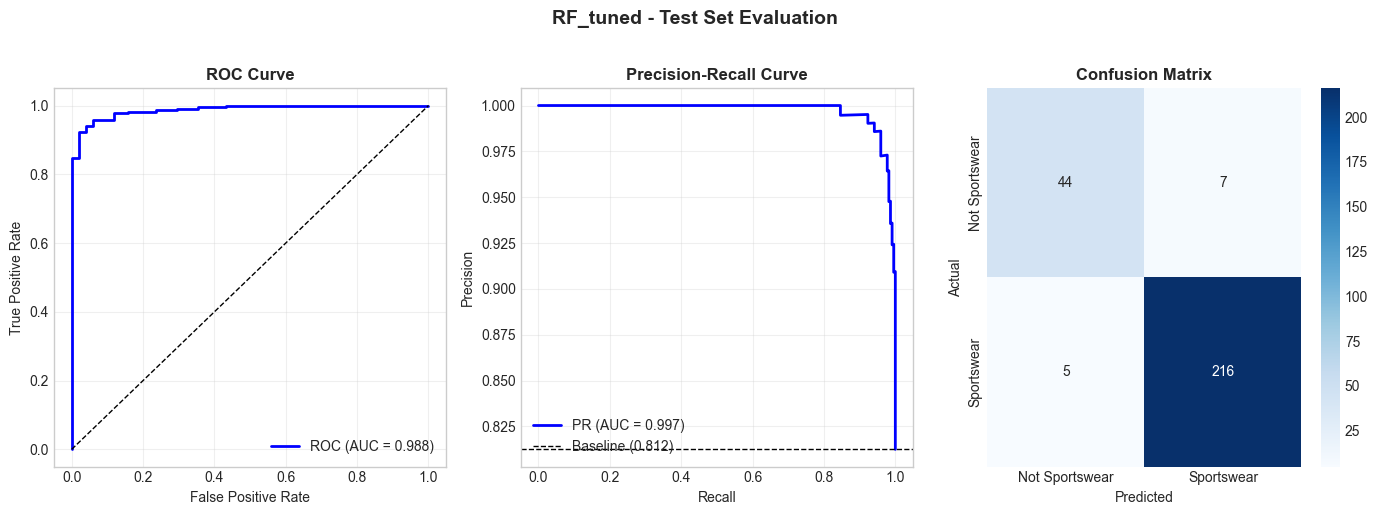

  F2 Score:  0.9756 (recall-weighted)


In [6]:
# Evaluate on held-out test set
test_metrics = evaluate_model(
    best_model, X_test, y_test,
    model_name=cv_metrics['model_name'],
    dataset_name='Test',
    verbose=True,
    plot=True,
    save_path='images/fp_test_evaluation.png'
)

# Add F2 score
y_pred_test = best_model.predict(X_test)
test_metrics['f2'] = fbeta_score(y_test, y_pred_test, beta=2)
print(f"  F2 Score:  {test_metrics['f2']:.4f} (recall-weighted)")

In [7]:
# Compare CV vs Test performance (generalization check)
print("=" * 60)
print("GENERALIZATION CHECK: CV vs Test Performance")
print("=" * 60)
print(f"\n{'Metric':<15} {'CV':>10} {'Test':>10} {'Gap':>10}")
print("-" * 45)

metrics_to_compare = ['f2', 'recall', 'precision']
for metric in metrics_to_compare:
    cv_val = cv_metrics[f'cv_{metric}']
    test_val = test_metrics[metric]
    gap = test_val - cv_val
    status = "OK" if abs(gap) < 0.05 else "WATCH"
    print(f"{metric.upper():<15} {cv_val:>10.4f} {test_val:>10.4f} {gap:>+10.4f}  [{status}]")

print("-" * 45)
print("\nNote: Small gaps (< 0.05) indicate good generalization.")
print("=" * 60)

GENERALIZATION CHECK: CV vs Test Performance

Metric                  CV       Test        Gap
---------------------------------------------
F2                  0.9825     0.9756    -0.0069  [OK]
RECALL              0.9932     0.9774    -0.0158  [OK]
PRECISION           0.9418     0.9686    +0.0268  [OK]
---------------------------------------------

Note: Small gaps (< 0.05) indicate good generalization.


## 4. Threshold Optimization

Analyze precision-recall trade-offs at different thresholds and select optimal threshold for target recall.

In [8]:
# Get predicted probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Analyze threshold tradeoffs
threshold_df = analyze_threshold_tradeoffs(
    y_test, y_proba,
    target_recalls=[0.90, 0.95, 0.97, 0.98, 0.99],
    verbose=True
)

THRESHOLD ANALYSIS: Recall vs Precision Trade-off

Total positives: 221, Total negatives: 51

--------------------------------------------------------------------------------
  Target | Threshold |   Recall | Precision |     F2 |    FPs |    FNs
--------------------------------------------------------------------------------
    90% |    0.7642 |   90.0% |    99.5% | 0.9179 |      1 |     22
    95% |    0.6127 |   95.0% |    98.6% | 0.9572 |      3 |     11
    97% |    0.5466 |   97.3% |    97.3% | 0.9729 |      6 |      6
    98% |    0.4587 |   98.2% |    96.4% | 0.9784 |      8 |      4
    99% |    0.3890 |   99.1% |    93.6% | 0.9794 |     15 |      2
--------------------------------------------------------------------------------

Lower threshold = Higher recall but more FPs pass to downstream processing


In [9]:
# Find optimal threshold for target recall
optimal_threshold, threshold_metrics = find_optimal_threshold(
    y_test, y_proba,
    target_recall=TARGET_RECALL
)

print("=" * 60)
print("OPTIMAL THRESHOLD FOR DEPLOYMENT")
print("=" * 60)
print(f"\nTarget recall: {TARGET_RECALL:.0%}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"\nMetrics at optimal threshold:")
print(f"  Actual Recall:    {threshold_metrics['actual_recall']:.4f}")
print(f"  Precision:        {threshold_metrics['precision']:.4f}")
print(f"  F2 Score:         {threshold_metrics['f2_score']:.4f}")
print(f"  True Positives:   {threshold_metrics['true_positives']}")
print(f"  False Positives:  {threshold_metrics['false_positives']} (passed to LLM)")
print(f"  False Negatives:  {threshold_metrics['false_negatives']} (sportswear missed)")
print("=" * 60)

OPTIMAL THRESHOLD FOR DEPLOYMENT

Target recall: 99%
Optimal threshold: 0.3890

Metrics at optimal threshold:
  Actual Recall:    0.9910
  Precision:        0.9359
  F2 Score:         0.9794
  True Positives:   219
  False Positives:  15 (passed to LLM)
  False Negatives:  2 (sportswear missed)


Figure saved to images/fp_threshold_tradeoff.png


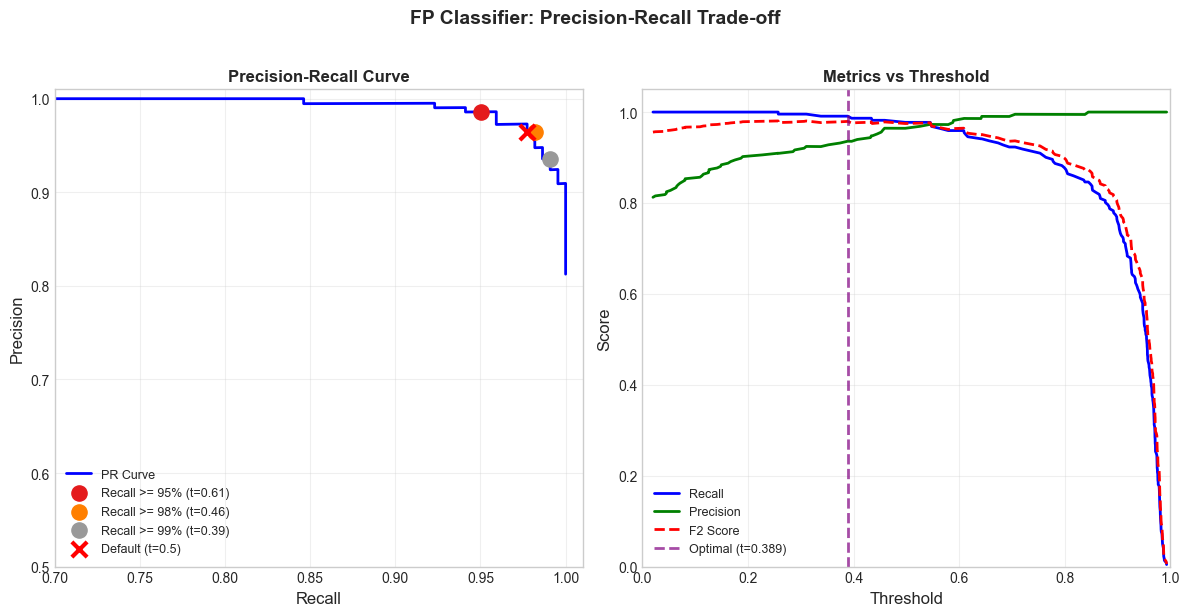

In [10]:
# Plot threshold analysis
fig = plot_threshold_analysis(
    y_test, y_proba,
    target_recalls=[0.95, 0.98, 0.99],
    optimal_threshold=optimal_threshold,
    title='FP Classifier: Precision-Recall Trade-off',
    save_path='images/fp_threshold_tradeoff.png'
)

## 5. Model Explainability

Understand what drives model predictions using three complementary approaches:
1. **LIME**: Word-level importance for individual predictions
2. **SHAP Feature Groups**: Aggregate importance by feature type
3. **Prototype Explanations**: Similar training examples

In [11]:
# Get feature groups for the FP classifier's feature method
feature_groups = get_fp_feature_groups(transformer.method)
print(f"Feature method: {transformer.method}")
print(f"\nFeature groups ({sum(len(list(v)) for v in feature_groups.values())} total features):")
for name, indices in feature_groups.items():
    print(f"  {name}: {len(list(indices))} features (indices {min(indices)}-{max(indices)})")

# Define example articles for explainability analysis
# These will also be used in Pipeline Validation section
example_articles = {
    "sportswear": {
        "title": "Nike Announces 50% Carbon Emissions Reduction Target",
        "content": "Nike Inc. unveiled ambitious sustainability goals at their annual investor conference. The athletic footwear giant plans to reduce carbon emissions by 50% across their global manufacturing operations by 2030. CEO John Donahoe emphasized the company's commitment to environmental responsibility while maintaining competitive pricing on their athletic shoes and apparel.",
        "brands": ["Nike"],
        "source_name": "ESPN",
        "category": ["sports", "business"],
    },
    "false_positive": {
        "title": "Wild Puma Spotted Near Hiking Trail in Montana Wilderness",
        "content": "Wildlife researchers captured rare footage of a wild puma in the remote wilderness of Montana. The majestic mountain lion was observed hunting deer near popular hiking trails in Glacier National Park. Rangers have issued warnings to hikers to maintain safe distances from wildlife. Conservation experts say the puma population in the region is recovering.",
        "brands": ["Puma"],
        "source_name": "National Geographic",
        "category": ["science", "environment", "wildlife"],
    }
}

# Prepare text for LIME analysis
sportswear_article = example_articles["sportswear"]
sportswear_text = sportswear_article['title'] + ' ' + sportswear_article['content']

fp_article = example_articles["false_positive"]
fp_text = fp_article['title'] + ' ' + fp_article['content']

print("\nExample articles prepared for explainability analysis.")

Feature method: tfidf_lsa_ner_proximity_brands

Feature groups (188 total features):
  lsa_features: 100 features (indices 0-99)
  ner_features: 6 features (indices 100-105)
  brand_ner_features: 8 features (indices 106-113)
  proximity_features: 4 features (indices 114-117)
  negative_context: 4 features (indices 118-121)
  fp_indicators: 13 features (indices 122-134)
  brand_indicators: 50 features (indices 135-184)
  brand_summary: 3 features (indices 185-187)

Example articles prepared for explainability analysis.


### 5.1 SHAP Feature Group Importance

Aggregate SHAP values by feature group to understand which types of features drive predictions most.

In [12]:
# Initialize explainer with feature groups
explainer = TextExplainer(
    pipeline=best_model,
    feature_groups=feature_groups,
    class_names=["false_positive", "sportswear"],
    threshold=optimal_threshold,
)

# Compute feature group importance using SHAP
# This aggregates SHAP values by feature type (embeddings, NER, etc.)
print("Computing SHAP feature group importance...")
print("(This may take a minute for tree models)")

shap_importance = explainer.explain_feature_groups(
    X_test,
    sample_size=100,  # Use subset for speed
    use_tree_explainer=True,  # Faster for RandomForest
)

# Display results
print("\n" + "=" * 60)
print("FEATURE GROUP IMPORTANCE (SHAP)")
print("=" * 60)
print(f"\n{'Feature Group':<25} {'Mean |SHAP|':>15} {'Contribution':>15}")
print("-" * 55)
for group, importance in shap_importance.top_groups:
    contribution = shap_importance.group_contribution[group]
    print(f"{group:<25} {importance:>15.4f} {contribution:>14.1%}")
print("-" * 55)

Computing SHAP feature group importance...
(This may take a minute for tree models)

FEATURE GROUP IMPORTANCE (SHAP)

Feature Group                 Mean |SHAP|    Contribution
-------------------------------------------------------
lsa_features                       0.0031          48.5%
brand_summary                      0.0006           9.4%
negative_context                   0.0006           8.6%
proximity_features                 0.0005           7.9%
ner_features                       0.0005           7.1%
brand_ner_features                 0.0004           6.6%
brand_indicators                   0.0004           6.5%
fp_indicators                      0.0004           5.4%
-------------------------------------------------------


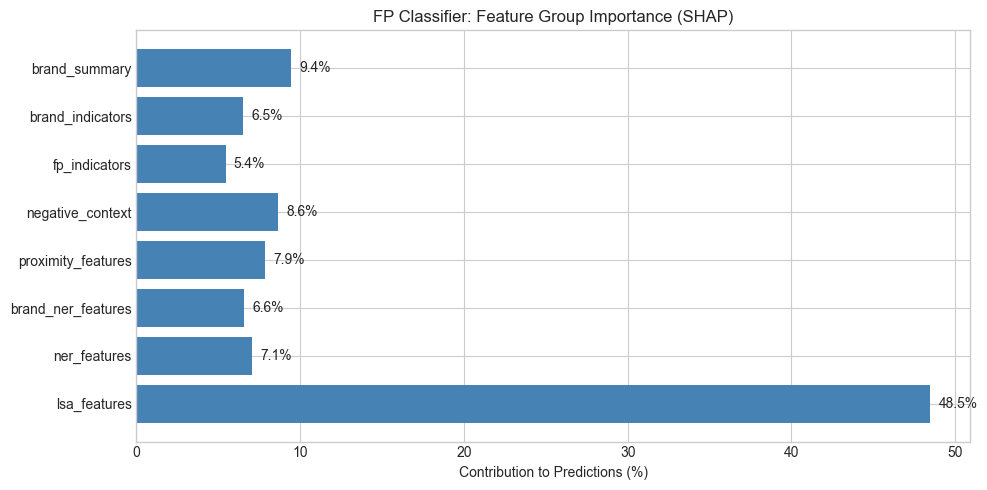


Interpretation:
- LSA/Sentence Embedding features capture the semantic content of articles
- NER features identify entity types near brand mentions (GPE, ORG, etc.)
- Proximity features measure distance to sportswear/non-sportswear keywords
- Brand features indicate which specific brand is mentioned


In [13]:
# Visualize feature group contributions
fig, ax = plt.subplots(figsize=(10, 5))

groups = list(shap_importance.group_contribution.keys())
contributions = [shap_importance.group_contribution[g] * 100 for g in groups]

bars = ax.barh(groups, contributions, color='steelblue')
ax.set_xlabel('Contribution to Predictions (%)')
ax.set_title('FP Classifier: Feature Group Importance (SHAP)')

# Add value labels
for bar, val in zip(bars, contributions):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('images/fp_feature_group_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- LSA/Sentence Embedding features capture the semantic content of articles")
print("- NER features identify entity types near brand mentions (GPE, ORG, etc.)")
print("- Proximity features measure distance to sportswear/non-sportswear keywords")
print("- Brand features indicate which specific brand is mentioned")

### 5.2 LIME Word-Level Explanations

LIME perturbs input text and observes prediction changes to identify influential words.

In [14]:
# LIME explanation for sportswear article
print("=" * 60)
print("LIME EXPLANATION: Sportswear Article")
print("=" * 60)

lime_sportswear = explainer.explain_lime(
    text=sportswear_text,
    transformer=transformer,
    source_name=sportswear_article['source_name'],
    categories=sportswear_article['category'],
    num_features=10,
)

print(f"\nPrediction: {lime_sportswear.prediction} ({lime_sportswear.probability:.1%})")
print(f"\nTop influential words:")
print("-" * 40)
for word, weight in lime_sportswear.top_words:
    direction = "→ sportswear" if weight > 0 else "→ false positive"
    print(f"  {word:20s} {weight:+.4f} {direction}")
print("-" * 40)
print(f"\n{lime_sportswear._generate_text_explanation()}")

LIME EXPLANATION: Sportswear Article

Prediction: sportswear (86.7%)

Top influential words:
----------------------------------------
  Nike                 +0.2496 → sportswear
  athletic             +0.0299 → sportswear
  environmental        -0.0206 → false positive
  plans                -0.0187 → false positive
  commitment           -0.0153 → false positive
  Announces            -0.0148 → false positive
  apparel              +0.0137 → sportswear
  footwear             +0.0122 → sportswear
  CEO                  +0.0115 → sportswear
  investor             +0.0094 → sportswear
----------------------------------------

Classified as sportswear (86.7% confidence). Key words supporting this: Nike, athletic, apparel. Words suggesting otherwise: environmental, plans, commitment.


In [15]:
# LIME explanation for false positive article
print("=" * 60)
print("LIME EXPLANATION: False Positive Article (Puma wildlife)")
print("=" * 60)

lime_fp = explainer.explain_lime(
    text=fp_text,
    transformer=transformer,
    source_name=fp_article['source_name'],
    categories=fp_article['category'],
    num_features=10,
)

print(f"\nPrediction: {lime_fp.prediction} ({lime_fp.probability:.1%})")
print(f"\nTop influential words:")
print("-" * 40)
for word, weight in lime_fp.top_words:
    direction = "→ sportswear" if weight > 0 else "→ false positive"
    print(f"  {word:20s} {weight:+.4f} {direction}")
print("-" * 40)
print(f"\n{lime_fp._generate_text_explanation()}")
print("\nNote: Words like 'wildlife', 'mountain', 'hiking' push toward false positive,")
print("while 'Hiking', 'Trail', and 'mountain' push towards sportswear.")

LIME EXPLANATION: False Positive Article (Puma wildlife)

Prediction: false_positive (65.4%)

Top influential words:
----------------------------------------
  Park                 -0.0949 → false positive
  National             -0.0908 → false positive
  Conservation         -0.0476 → false positive
  remote               -0.0403 → false positive
  Hiking               +0.0319 → sportswear
  Puma                 +0.0303 → sportswear
  Trail                +0.0278 → sportswear
  hiking               +0.0212 → sportswear
  wilderness           +0.0143 → sportswear
  Wilderness           +0.0046 → sportswear
----------------------------------------

Classified as false_positive (65.4% confidence). Key words supporting this: Hiking, Puma, Trail. Words suggesting otherwise: Park, National, Conservation.

Note: Words like 'wildlife', 'mountain', 'hiking' push toward false positive,
while 'Hiking', 'Trail', and 'mountain' push towards sportswear.


### 5.3 Prototype-Based Explanations

Find similar training examples to explain predictions through analogy.

In [16]:
# Transform training data for prototype explanations
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()

X_train = transformer.transform(
    train_df['text_features'],
    source_names=train_source_names,
    categories=train_categories
)

# Fit the prototype explainer on training embeddings
explainer.fit_prototype_explainer(X_train, metric='cosine')
print(f"Prototype explainer fitted on {X_train.shape[0]} training examples")

Prototype explainer fitted on 813 training examples


In [17]:
# Prototype explanation for the false positive article
print("=" * 80)
print("PROTOTYPE EXPLANATION: False Positive Article (Puma wildlife)")
print("=" * 80)
print("""
How prototype explanations work:
- Find training examples most similar to the query article (in feature space)
- Show their labels to provide intuition about the prediction
- If similar examples share the same label, it supports the model's prediction
""")

proto_fp = explainer.explain_prototype(
    text=fp_text,
    train_df=train_df,
    transformer=transformer,
    source_name=fp_article['source_name'],
    categories=fp_article['category'],
    n_neighbors=5,
    title_col='title',
    label_col='is_sportswear',
    text_col='text_features',
)

print(f"Query article: {fp_article['title'][:60]}...")
print(f"Model prediction: {proto_fp.prediction} ({proto_fp.probability:.1%})")
print(f"\nMost similar training examples (by cosine similarity in feature space):")
print("-" * 80)
for i, example in enumerate(proto_fp.similar_examples, 1):
    label_str = "SPORTSWEAR" if example['label'] == 'sportswear' else "FALSE POSITIVE"
    print(f"\n{i}. [{label_str}] Similarity: {example['similarity']:.3f}")
    print(f"   Title: {example['title'][:75]}")
print("-" * 80)

# Analyze label distribution for interpretation
similar_labels = [ex['label'] for ex in proto_fp.similar_examples]
fp_count = sum(1 for l in similar_labels if l == 'false_positive')
sw_count = len(similar_labels) - fp_count

print(f"\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print(f"""
Label distribution among 5 nearest neighbors:
  - False Positive: {fp_count}/5
  - Sportswear: {sw_count}/5
""")

if fp_count == len(similar_labels):
    print("""What this means:
ALL 5 most similar training examples are labeled 'false_positive'. This strongly
supports the model's prediction. The query article about a wild Puma is most
similar to other articles in our training set that were also NOT about the
sportswear brand (e.g., zoo animals, Ford Puma cars, wildlife stories).

This is a k-NN style explanation: "Predict false_positive because all similar
training articles were also false positives."
""")
elif fp_count > sw_count:
    print(f"""What this means:
The majority ({fp_count}/5) of similar training examples are 'false_positive',
which supports the model's prediction. However, {sw_count} similar examples
were sportswear articles, suggesting some feature overlap.
""")
else:
    print(f"""What this means:
Interestingly, most similar examples ({sw_count}/5) are sportswear articles,
yet the model predicted 'false_positive'. This suggests other features
(like NER entities, proximity scores) outweighed the semantic similarity.
""")
print("=" * 80)

PROTOTYPE EXPLANATION: False Positive Article (Puma wildlife)

How prototype explanations work:
- Find training examples most similar to the query article (in feature space)
- Show their labels to provide intuition about the prediction
- If similar examples share the same label, it supports the model's prediction

Query article: Wild Puma Spotted Near Hiking Trail in Montana Wilderness...
Model prediction: false_positive (65.4%)

Most similar training examples (by cosine similarity in feature space):
--------------------------------------------------------------------------------

1. [FALSE POSITIVE] Similarity: 0.886
   Title: Muddy eruption at Yellowstone’s Black Diamond Pool captured on video

2. [SPORTSWEAR] Similarity: 0.721
   Title: Nike sells out the tracksuit worn by Maduro at the moment he was captured b

3. [FALSE POSITIVE] Similarity: 0.484
   Title: Study: Tanning beds nearly triple risk of melanoma

4. [FALSE POSITIVE] Similarity: 0.177
   Title: Caldwell Zoo announces de

## 6. Export for Deployment

Create and save the complete pipeline (transformer + classifier) for Docker API deployment.

In [18]:
# Create deployment pipeline
full_pipeline = create_deployment_pipeline(
    transformer=transformer,
    classifier=best_model,
    pipeline_name='fp_classifier'
)

print(f"Created pipeline: {full_pipeline}")

Created pipeline: Pipeline(steps=[('features',
                 FPFeatureTransformer(include_brand_indicators=True, lsa_n_components=300, method='tfidf_lsa_ner_proximity_brands')),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=12, n_estimators=350,
                                        n_jobs=-1, random_state=42))])


In [19]:
# Prepare deployment configuration
deployment_config = {
    # Threshold settings
    'threshold': float(optimal_threshold),
    'target_recall': TARGET_RECALL,
    
    # Model info
    'model_name': cv_metrics['model_name'],
    'transformer_method': transformer.method,
    'best_params': cv_metrics['best_params'],
    
    # CV performance
    'cv_f2': cv_metrics['cv_f2'],
    'cv_recall': cv_metrics['cv_recall'],
    'cv_precision': cv_metrics['cv_precision'],
    
    # Test performance
    'test_f2': float(test_metrics['f2']),
    'test_recall': float(test_metrics['recall']),
    'test_precision': float(test_metrics['precision']),
    
    # Performance at threshold
    'threshold_recall': float(threshold_metrics['actual_recall']),
    'threshold_precision': float(threshold_metrics['precision']),
    'threshold_f2': float(threshold_metrics['f2_score']),
}

# Save deployment artifacts
saved_paths = save_deployment_artifacts(
    pipeline=full_pipeline,
    config=deployment_config,
    models_dir=MODELS_DIR,
    pipeline_name='fp_classifier'
)

Pipeline saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_pipeline.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_config.json


## 7. Pipeline Validation

Test the exported pipeline on sample texts to ensure it works correctly.

In [20]:
# Define realistic validation articles with full metadata
# Each article includes title, content, brands, source_name, category, and expected_label
#
# These examples are designed to test edge cases:
# - True positives: Clear sportswear brand articles from sports/business sources
# - False positives: Challenging cases where brand names have non-sportswear meanings
#   (Puma the animal, Patagonia the region, Columbia the university, New Balance as a phrase)

validation_articles = [
    # ===== TRUE SPORTSWEAR ARTICLES (expected_label=1) =====
    {
        "title": "Nike Announces 50% Carbon Emissions Reduction Target",
        "content": "Nike Inc. unveiled ambitious sustainability goals at their annual investor conference. The athletic footwear giant plans to reduce carbon emissions by 50% across their global manufacturing operations by 2030. CEO John Donahoe emphasized the company's commitment to environmental responsibility while maintaining competitive pricing on their athletic shoes and apparel.",
        "brands": ["Nike"],
        "source_name": "ESPN",
        "category": ["sports", "business"],
        "expected_label": 1
    },
    {
        "title": "Adidas Partners with Parley for Recycled Ocean Plastic Sneakers",
        "content": "German sportswear manufacturer Adidas has expanded its partnership with Parley for the Oceans to produce over 15 million pairs of shoes using recycled ocean plastic. The collaboration represents a significant step in sustainable athletic footwear production. The new Ultraboost line features uppers made entirely from recycled materials.",
        "brands": ["Adidas"],
        "source_name": "Reuters",
        "category": ["business", "environment"],
        "expected_label": 1
    },
    {
        "title": "Under Armour Reports Strong Q3 Earnings Driven by Running Shoe Sales",
        "content": "Under Armour Inc. exceeded analyst expectations with quarterly revenue of $1.6 billion. The Baltimore-based athletic apparel company saw particular strength in their running footwear segment, with the HOVR line driving double-digit growth. CFO David Bergman highlighted improved margins in the direct-to-consumer channel.",
        "brands": ["Under Armour"],
        "source_name": "Wall Street Journal",
        "category": ["business", "finance"],
        "expected_label": 1
    },
    {
        "title": "Lululemon Opens New Factory in Vietnam to Meet Yoga Apparel Demand",
        "content": "Lululemon Athletica announced plans to open a new manufacturing facility in Vietnam to meet growing global demand for their yoga and athletic apparel. The facility will employ 2,000 workers and incorporate sustainable manufacturing practices. The company expects the factory to be operational by Q2 2025.",
        "brands": ["Lululemon"],
        "source_name": "Bloomberg",
        "category": ["business"],
        "expected_label": 1
    },
    
    # ===== FALSE POSITIVE EDGE CASES (expected_label=0) =====
    # These are intentionally challenging - brand names with alternate meanings
    {
        "title": "Wild Puma Spotted Near Hiking Trail in Montana Wilderness",
        "content": "Wildlife researchers captured rare footage of a wild puma in the remote wilderness of Montana. The majestic mountain lion was observed hunting deer near popular hiking trails in Glacier National Park. Rangers have issued warnings to hikers to maintain safe distances from wildlife. Conservation experts say the puma population in the region is recovering.",
        "brands": ["Puma"],
        "source_name": "National Geographic",
        "category": ["science", "environment", "wildlife"],
        "expected_label": 0
    },
    {
        "title": "Patagonia Region Sees Record Tourism as Glaciers Draw Visitors",
        "content": "The Patagonia region spanning southern Chile and Argentina has experienced a surge in eco-tourism. Visitors flock to see the stunning glaciers, pristine lakes, and diverse wildlife including penguins and guanacos. Tour operators report a 40% increase in bookings compared to last year. The region's national parks have implemented new conservation measures.",
        "brands": ["Patagonia"],
        "source_name": "Travel + Leisure",
        "category": ["travel", "tourism"],
        "expected_label": 0
    },
    {
        "title": "Columbia University Announces New Climate Research Initiative",
        "content": "Columbia University's Earth Institute has launched a $50 million climate research initiative. The program will study the impacts of climate change on urban environments and develop adaptation strategies. Professor James Hansen, a renowned climate scientist, will lead the research team. The initiative is funded by a combination of federal grants and private donations.",
        "brands": ["Columbia"],
        "source_name": "New York Times",
        "category": ["education", "science"],
        "expected_label": 0
    },
    {
        "title": "New Balance of Power in Middle East Following Peace Accord",
        "content": "Diplomatic analysts are assessing the new balance of power in the Middle East following the historic peace agreement signed in Cairo. The accord has shifted regional alliances and opened new economic opportunities. Political experts suggest the agreement could lead to reduced military spending and increased trade cooperation among participating nations.",
        "brands": ["New Balance"],
        "source_name": "Al Jazeera",
        "category": ["politics", "world"],
        "expected_label": 0
    },
]

# Validate pipeline with realistic articles
validation_results = validate_pipeline_with_articles(
    pipeline=full_pipeline,
    articles=validation_articles,
    threshold=optimal_threshold,
    verbose=True
)

# Detailed analysis
print("\n" + "=" * 80)
print("VALIDATION ANALYSIS")
print("=" * 80)

# Separate results by category
true_positives = [a for a, p in zip(validation_articles, validation_results['predictions_at_threshold']) 
                  if a['expected_label'] == 1]
false_positive_cases = [a for a in validation_articles if a['expected_label'] == 0]
fp_probs = [p for a, p in zip(validation_articles, validation_results['probabilities']) 
            if a['expected_label'] == 0]

tp_correct = sum(1 for a, p in zip(validation_articles, validation_results['predictions_at_threshold'])
                 if a['expected_label'] == 1 and p == 1)
fp_correct = sum(1 for a, p in zip(validation_articles, validation_results['predictions_at_threshold'])
                 if a['expected_label'] == 0 and p == 0)

print(f"\nTrue Sportswear Articles: {tp_correct}/{len(true_positives)} correctly classified")
print(f"False Positive Edge Cases: {fp_correct}/{len(false_positive_cases)} correctly filtered")

print(f"\nFalse Positive Probabilities (should be < {optimal_threshold:.3f}):")
for article, prob in zip(false_positive_cases, fp_probs):
    status = "PASS" if prob < optimal_threshold else "FAIL"
    margin = optimal_threshold - prob
    print(f"  [{status}] {prob:.3f} (margin: {margin:+.3f}) - {article['brands'][0]}")

print("\n" + "-" * 80)
print("NOTE: False positive edge cases are intentionally challenging. These represent")
print("brand names with alternate meanings (Puma=animal, Patagonia=region, etc.).")
print("The classifier prioritizes recall (catching sportswear) over precision on edge cases.")
print("In production, these borderline cases would be passed to LLM for verification.")
print("=" * 80)


PIPELINE VALIDATION WITH ARTICLES

Threshold: 0.3890
Samples tested: 8
Accuracy: 75.0% (6/8)

Results:
--------------------------------------------------------------------------------

[1] ✓ Prob: 0.962 | Pred: Sportswear | Expected: Sportswear
    Title: Nike Announces 50% Carbon Emissions Reduction Targ...
    Source: ESPN | Brands: Nike

[2] ✓ Prob: 0.953 | Pred: Sportswear | Expected: Sportswear
    Title: Adidas Partners with Parley for Recycled Ocean Pla...
    Source: Reuters | Brands: Adidas

[3] ✓ Prob: 0.944 | Pred: Sportswear | Expected: Sportswear
    Title: Under Armour Reports Strong Q3 Earnings Driven by ...
    Source: Wall Street Journal | Brands: Under Armour

[4] ✓ Prob: 0.938 | Pred: Sportswear | Expected: Sportswear
    Title: Lululemon Opens New Factory in Vietnam to Meet Yog...
    Source: Bloomberg | Brands: Lululemon

[5] ✗ Prob: 0.462 | Pred: Sportswear | Expected: FP
    Title: Wild Puma Spotted Near Hiking Trail in Montana Wil...
    Source: National Geogra

In [21]:
print("=" * 60)
print("FP3 NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nBest Model: {cv_metrics['model_name']}")
print(f"Feature Method: {transformer.method}")
print(f"\nCV Performance:")
print(f"  F2 Score:  {cv_metrics['cv_f2']:.4f}")
print(f"  Recall:    {cv_metrics['cv_recall']:.4f}")
print(f"  Precision: {cv_metrics['cv_precision']:.4f}")
print(f"\nTest Set Performance:")
print(f"  F2 Score:  {test_metrics['f2']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"\nDeployment Settings:")
print(f"  Target Recall: {TARGET_RECALL:.0%}")
print(f"  Threshold:     {optimal_threshold:.4f}")
print(f"\nAt Deployment Threshold:")
print(f"  F2 Score:  {threshold_metrics['f2_score']:.4f}")
print(f"  Recall:    {threshold_metrics['actual_recall']:.4f}")
print(f"  Precision: {threshold_metrics['precision']:.4f}")
print(f"\nSaved Artifacts:")
for name, path in saved_paths.items():
    print(f"  - {path}")
print("=" * 60)

FP3 NOTEBOOK SUMMARY

Best Model: RF_tuned
Feature Method: tfidf_lsa_ner_proximity_brands

CV Performance:
  F2 Score:  0.9825
  Recall:    0.9932
  Precision: 0.9418

Test Set Performance:
  F2 Score:  0.9756
  Recall:    0.9774
  Precision: 0.9686

Deployment Settings:
  Target Recall: 99%
  Threshold:     0.3890

At Deployment Threshold:
  F2 Score:  0.9794
  Recall:    0.9910
  Precision: 0.9359

Saved Artifacts:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_pipeline.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_config.json


## Next Steps

1. **Deploy Model**: Integrate `fp_classifier_pipeline.joblib` into Docker API service
2. **Configure Threshold**: Use `fp_classifier_config.json` for threshold and settings
3. **Monitor Performance**: Track F2/recall on new data to detect drift
4. **Retrain Periodically**: Update model as more labeled data becomes available
5. **Add Explainability to API** (optional): Include LIME explanations in prediction responses